In [161]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [162]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train = df_train.drop(["id"], axis=1)
df_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [163]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers as ly
from tensorflow.keras.models import Sequential

In [164]:
import random

random.seed(42)

In [165]:
sentences = np.array(df_train["text"])
sentences[:4]

labels = np.array(df_train["target"])

random.shuffle(labels)
random.shuffle(sentences)

In [166]:
VOCAB_SIZE = 50000
MAX_LENGTH = 100
EMBEDDING_DIM = 16

In [167]:
tokenizer = Tokenizer(oov_token="<START>")
tokenizer.fit_on_texts(sentences)

In [168]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding="post", truncating="post")

In [169]:
sequences[:2]

[[6955, 2159, 14, 5, 2454, 423, 1501, 9, 97, 105, 97, 8, 642, 5, 2922],
 [6956, 16, 1752, 1502, 8, 28, 6, 442, 800, 58, 1753, 251, 5, 379, 1754, 2455]]

In [170]:
padded[:2]

array([[6955, 2159,   14,    5, 2454,  423, 1501,    9,   97,  105,   97,
           8,  642,    5, 2922,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [6956,   16, 1752, 1502,    8,   28,    6,  442,  800,   58, 1753,
         251,    5,  379, 1754, 2455,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [171]:
# VOCAB_SIZE = len(tokenizer.word_index)+1

In [172]:
model = Sequential([
    ly.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
#     ly.Bidirectional(ly.LSTM(32)),
    ly.Dropout(0.7),
    ly.GlobalAveragePooling1D(),
    ly.Dense(24, activation="relu"),
#     ly.Bidirectional(ly.LSTM(32)),
    ly.Dropout(0.7),
    ly.Dense(24, activation="relu"),
    ly.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [173]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 16)           363232    
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 24)                408       
_________________________________________________________________
dropout_15 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [174]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback = ModelCheckpoint("model_NLP.h5", monitor="val_accuracy", save_best_only=True)

In [175]:
len(sequences)

7613

In [176]:
SPLIT = 1000
train_x = padded[SPLIT:]
train_y = labels[SPLIT:]

val_x = padded[:SPLIT]
val_y = labels[:SPLIT]

In [177]:
history = model.fit(train_x, train_y,
                    epochs=5,
                    validation_data=(val_x, val_y),
                    callbacks=[callback],
                    verbose=2)

Epoch 1/5
207/207 - 1s - loss: 0.6859 - accuracy: 0.5668 - val_loss: 0.6808 - val_accuracy: 0.5800
Epoch 2/5
207/207 - 1s - loss: 0.6839 - accuracy: 0.5689 - val_loss: 0.6806 - val_accuracy: 0.5800
Epoch 3/5
207/207 - 1s - loss: 0.6826 - accuracy: 0.5689 - val_loss: 0.6803 - val_accuracy: 0.5800
Epoch 4/5
207/207 - 1s - loss: 0.6745 - accuracy: 0.5699 - val_loss: 0.6812 - val_accuracy: 0.5800
Epoch 5/5
207/207 - 1s - loss: 0.6442 - accuracy: 0.6145 - val_loss: 0.6968 - val_accuracy: 0.5380


In [178]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

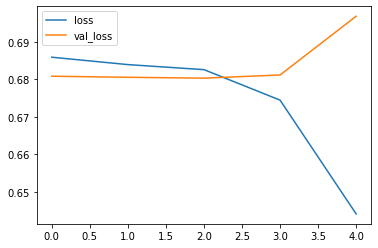

In [179]:
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["loss", "val_loss"])
plt.show()

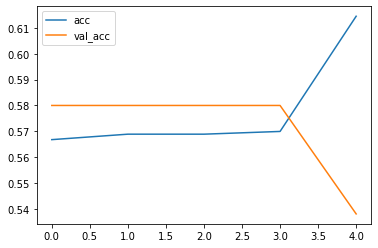

In [180]:
plt.plot(acc)
plt.plot(val_acc)
plt.legend(["acc", "val_acc"])
plt.show()

In [181]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_test = df_test.drop(["id"], axis=1)
df_test.head()

,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [182]:
test_x = np.array(df_test["text"])
tokenizer.fit_on_texts(test_x)
test_x = tokenizer.texts_to_sequences(sentences)
test_x = pad_sequences(test_x, padding="post", truncating="post")

In [183]:
prediction = model.predict(test_x)

InvalidArgumentError:  indices[6,0] = 22702 is not in [0, 22702)
	 [[node sequential_11/embedding_11/embedding_lookup (defined at <ipython-input-183-2faa12f64b8e>:1) ]] [Op:__inference_predict_function_97653]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_11/embedding_11/embedding_lookup:
 sequential_11/embedding_11/embedding_lookup/97622 (defined at /opt/conda/lib/python3.7/contextlib.py:112)

Function call stack:
predict_function


In [ ]:
for i in range(10):
    result = "FAKE" if prediction[i] > 0.5 else "REAL"
    print(df_test.iloc[i]["text"], " - ", result)